Sailing The Seaborn! Below are the majority 4 topics here

1. Examine call volume and identify surge times, seasons, or events.

Let's try and do this by looking at peak hours and days. Then with that info we can look to see if there was a specific event that occured then? Seasonality or looking at sunrise/sunset times would be helpful as well.

2. Analyze trends in call content by looking for which issues are most frequent and what is the average count of issues per call.

This will likely be regex heavy? Would be searching for keywords within the call dialogue.

3. Assess regional and demographic trends in call content and call volume.

This is just like doing #2 but including demographics

4. Determine the count and success rate of imminent risk calls.

This seems the easiest, would be used best when paired with the other means of looking into the data

In [2]:
pip install sunriset

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
import sunriset
from datetime import datetime
from suntimes import SunTimes
from datetime import timedelta
import math
import pytz
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


%matplotlib inline

I am importing these items as it is fortold in the python commandments

In [4]:
crisis1 = pd.read_excel('../data/Crisis1.xlsx', header=2)
crisis2 = pd.read_excel('../data/Crisis2.xlsx', header=2)

In [5]:
crisis1.head()

,CallReportNum,ReportVersion,LinkedToCallReportNum,CallDateAndTimeStart,CallDateAndTimeEnd,CallLength,CallerNum,PhoneWorkerNum,PhoneWorkerName,WasRealCall,...,SUI AX Third-Party Risk Assessment Demographics - Income,SUI AX Third-Party Risk Assessment Demographics - SUI AX Does this risk assesment have different demographics than the caller? (Third-party Call),Suicide Assessment - Are you thinking of suicide?,Suicide Assessment - Caller is having thoughts of killing self or other,Suicide Assessment - Do you own a firearm?,Suicide Assessment - Have you ever attempted to kill yourself?,Suicide Assessment - Have you thought about suicide in the last two months?,Suicide Assessment - Suicide in progress?,Transfer Information - Were you transferred to this line from another crisis line or agency?,Transfer Information - Which line/agency transferred you to this Crisis Line?
0,96627022,Crisis,NaN,2021-12-31 23:35:00,2021-12-31 23:58:00,23,-1,136748,Lisa Crawford,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,96626934,Crisis,NaN,2021-12-31 23:29:00,2021-12-31 23:35:00,6,-1,136748,Lisa Crawford,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,96626654,Crisis,NaN,2021-12-31 23:07:00,2021-12-31 23:28:00,21,1030262,136748,Lisa Crawford,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,96626370,Crisis,NaN,2021-12-31 22:45:00,2021-12-31 22:55:00,10,2479348,136748,Lisa Crawford,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,96625909,Crisis,NaN,2021-12-31 22:15:00,2021-12-31 22:44:00,29,-1,136748,Lisa Crawford,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I'm converting the call times here to datetime format! Info & formatting pulled from here
https://www.geeksforgeeks.org/python-working-with-date-and-time-using-pandas/

In [6]:
crisis1['CallDateAndTimeStart'] = pd.to_datetime(crisis1['CallDateAndTimeStart'])
crisis1['CallDateAndTimeEnd'] = pd.to_datetime(crisis1['CallDateAndTimeEnd'])
crisis1['CallDateStartWeekdate'] = crisis1['CallDateAndTimeStart'].dt.day_name()
#CallDateStartWeekdate give a Monday, Tuesday etc result
crisis1['CallDateStartTime'] = crisis1['CallDateAndTimeStart'].dt.hour
#CallDateStartTime gives the hour of the day the call was made, military time
crisis1['month'] = crisis1['CallDateAndTimeStart'].dt.month
#CallDateStartMonth gives the month which the call was made
crisis1['CallDateStartDay'] = crisis1['CallDateAndTimeStart'].dt.day
#CallDateStartDay gives us the DD
#crisis1['CallDateStartYYYYMMDD'] = crisis1['CallDateAndTimeStart'].dt.year + '-' + crisis1['CallDateAndTimeStart'].dt.month + '-' + crisis1['CallDateAndTimeStart'].dt.day
crisis1['CallDateStartDay']

0        31
1        31
2        31
3        31
4        31
         ..
52871     1
52872     1
52873     1
52874     1
52875     1
Name: CallDateStartDay, Length: 52876, dtype: int64

Attempting to do a regex here so that I can make a kde seaborn plot for call length and call time of day, but I'm having an issue here of pulling the call time. I tried \d{2}:\d{2}:00 but that was coming up with nothing, somehow. I don't think colon is a strange character though? https://seaborn.pydata.org/generated/seaborn.kdeplot.html?highlight=kde%20plot#seaborn.kdeplot https://towardsdatascience.com/an-ultimate-cheatsheet-of-data-visualization-in-seaborn-be8ed13a3697 https://seaborn.pydata.org/tutorial/relational.html https://www.dataquest.io/wp-content/uploads/2019/03/python-regular-expressions-cheat-sheet.pdf

In [7]:
crisis1.dropna(how='all', axis=1, inplace=True)
crisis2.dropna(axis=1, how='all', inplace=True)

In [8]:
stats_2020 = pd.read_excel('../data/call_volume.xlsx', sheet_name='2020', skiprows=10, nrows=9, usecols='A:B')
stats_2020.rename(inplace=True, columns={'Total Calls':'Category', 'Unnamed: 1':'Total'})
#stats_2020['Total'].sub(' calls', '') this didn't work the way I wanted it to, commenting it out until I figure out how to fix it
stats_2020

,Category,Total
0,Number of Received Calls,45772 calls
1,Number of Answered Calls,28483 calls
2,Number of Abandoned Unanswered Call,9484 calls
3,Number of Other Unanswered Calls,6829 calls
4,Number of Transferred Calls,976 calls
5,Unanswered Rate,0.1492
6,Abandon Rate,0.2072
7,Agent Login,33332
8,Agent Logoff,33313


In [9]:
queue_dist_2020 = pd.read_excel('../data/call_volume.xlsx', sheet_name='2020', skiprows=23, nrows=12, usecols='A:I')
queue_dist_2020

,Queue,Received,Answered,Unanswered,Transfers,% Answ,% Unansw,Avg Durat.,Avg Wait
0,AWARE,11,8,3,0,0.7273,0.2727,00:02:04,00:01:44
1,Crisis Eng,22704,15281,7264,159,0.6681,0.3143,00:10:54,00:01:34
2,Crisis Eng PRIORITY,3200,2070,1056,74,0.6700,0.3300,00:10:32,00:01:59
3,Crisis Spanish,153,107,39,7,0.7355,0.2516,00:08:30,00:02:11
4,Crisis Spanish PRIORITY,16,13,2,1,0.8750,0.1250,00:07:50,00:01:58
5,Lifeline,6132,3542,2493,97,0.5934,0.4066,00:11:34,00:00:33
6,MHART,120,75,45,0,0.5474,0.3285,00:07:18,00:00:23
7,Pet Loss,0,0,0,0,0.0000,0.0000,00:00:00,00:00:00
8,REDLINE,11708,6422,4752,534,0.5941,0.4059,00:05:42,00:00:29
9,Referral Line,1358,888,366,104,0.7305,0.2695,00:03:32,00:00:24


In [10]:
month_dist_2020 = pd.read_excel('../data/call_volume.xlsx', sheet_name='2020', skiprows=39, nrows=12, usecols='A:K')
month_dist_2020

,Month,Received,Answered,Unanswered,Transfers,% Answ,% Unansw,Avg Durat.,Avg Wait,Logins,Logoff
0,2020-01,2880,1795,1033,52,0.6413,0.3587,00:08:58,00:01:15,3160,3160
1,2020-02 (2020-02),2704,1698,936,70,0.6538,0.3462,00:10:08,00:01:03,3462,3450
2,2020-03 (2020-03),4059,2537,1347,175,0.6681,0.3319,00:08:05,00:00:54,3223,3217
3,2020-04 (2020-04),3385,2152,1147,86,0.6612,0.3388,00:09:23,00:01:04,2758,2750
4,2020-05 (2020-05),3721,2239,1388,94,0.6270,0.3730,00:10:32,00:01:18,2369,2377
5,2020-06 (2020-06),3693,2221,1413,59,0.6174,0.3826,00:10:18,00:01:10,2415,2415
6,2020-07 (2020-07),3919,2543,1296,80,0.6693,0.3307,00:10:04,00:00:58,2678,2671
7,2020-08 (2020-08),4390,2527,1803,60,0.5893,0.4107,00:10:15,00:01:23,2465,2479
8,2020-09 (2020-09),3967,2442,1464,61,0.6310,0.3690,00:10:19,00:01:16,3087,3070
9,2020-10 (2020-10),4143,2617,1480,46,0.6428,0.3572,00:09:30,00:01:19,2887,2889


In [11]:
month_dist_2020['Month'].str.extract(r'((?<=\d{4}-)\d{2})')

,0
0,01
1,02
2,03
3,04
4,05
5,06
6,07
7,08
8,09
9,10


In [12]:
day_dist_2020 = pd.read_excel('../data/call_volume.xlsx', sheet_name='2020', skiprows=55, nrows=7, usecols='A:K')
day_dist_2020

,Day,Received,Answered,Unanswered,Transfers,% Answ,% Unansw,Avg Durat.,Avg Wait,Logins,Logoff
0,Sunday,6864,3576,3174,114,0.5376,0.4624,00:10:17,00:01:28,3641,3624
1,Monday,6811,4472,2187,152,0.6789,0.3211,00:08:38,00:00:59,5549,5576
2,Tuesday,6289,4138,2046,105,0.6747,0.3253,00:09:34,00:01:06,5544,5620
3,Wednesday,6608,4463,1981,164,0.7002,0.2998,00:09:13,00:00:58,5538,5696
4,Thursday,6370,4212,2003,155,0.6856,0.3144,00:09:34,00:00:59,4696,4779
5,Friday,6119,3939,2032,148,0.6679,0.3321,00:09:15,00:01:06,4646,4383
6,Saturday,6711,3683,2890,138,0.5694,0.4306,00:09:54,00:01:25,3718,3635


In [13]:
queue_answered_2020 = pd.read_excel('../data/call_volume.xlsx', sheet_name='2020', skiprows=66, nrows=10, usecols='A:C')
queue_answered_2020

,Queue,Count,%
0,AWARE,8 calls,0.0003
1,Crisis Eng,15281 calls,0.5365
2,Crisis Eng PRIORITY,2070 calls,0.0727
3,Crisis Spanish,107 calls,0.0038
4,Crisis Spanish PRIORITY,13 calls,0.0005
5,Lifeline,3542 calls,0.1244
6,MHART,75 calls,0.0026
7,REDLINE,6422 calls,0.2255
8,Referral Line,888 calls,0.0312
9,SAMHSA,77 calls,0.0027


In [14]:
service_speed_2020 = pd.read_excel('../data/call_volume.xlsx', sheet_name='2020', skiprows=80, nrows=10, usecols='A:D')
service_speed_2020

,Answer,Count,Delta,%
0,Within 15 secs,21405 calls,21405,0.7266
1,Within 30 secs,25052 calls,3647,0.8504
2,Within 45 secs,26068 calls,1016,0.8849
3,Within 60 secs,26734 calls,666,0.9075
4,Within 75 secs,27090 calls,356,0.9196
5,Within 90 secs,27310 calls,220,0.9271
6,Within 105 secs,27492 calls,182,0.9332
7,Within 120 secs,27677 calls,185,0.9395
8,Within 135 secs,27722 calls,45,0.9410
9,Within 150+ secs,29459 calls,1737,1.0000


In [15]:
abandon_rate_2020 = pd.read_excel('../data/call_volume.xlsx', sheet_name='2020', skiprows=94, nrows=10, usecols='A:D')
abandon_rate_2020

,Unanswer,Count,Delta,%
0,Within 15 secs,432 calls,432,0.0265
1,Within 30 secs,2012 calls,1580,0.1233
2,Within 45 secs,3656 calls,1644,0.2241
3,Within 60 secs,8659 calls,5003,0.5308
4,Within 75 secs,11113 calls,2454,0.6812
5,Within 90 secs,11637 calls,524,0.7134
6,Within 105 secs,12062 calls,425,0.7394
7,Within 120 secs,12403 calls,341,0.7603
8,Within 135 secs,12981 calls,578,0.7957
9,Within 150+ secs,16313 calls,3332,1.0000


In [16]:
stats_2021 = pd.read_excel('../data/call_volume.xlsx', sheet_name='2021', skiprows=10, nrows=9, usecols='A:B')
stats_2021.rename(inplace=True, columns={'Total Calls':'Category', 'Unnamed: 1':'Total'})
stats_2021

,Category,Total
0,Number of Received Calls,53975 calls
1,Number of Answered Calls,37036 calls
2,Number of Abandoned Unanswered Call,10841 calls
3,Number of Other Unanswered Calls,5215 calls
4,Number of Transferred Calls,883 calls
5,Unanswered Rate,0.0966
6,Abandon Rate,0.2009
7,Agent Login,37571
8,Agent Logoff,37534


In [17]:
queue_dist_2021 = pd.read_excel('../data/call_volume.xlsx', sheet_name='2021', skiprows=23, nrows=11, usecols='A:I')
queue_dist_2021

,Queue,Received,Answered,Unanswered,Transfers,% Answ,% Unansw,Avg Durat.,Avg Wait
0,Community Response,35,21,13,1,0.6111,0.3611,00:04:21,00:00:32
1,Crisis Eng,28017,20723,7152,142,0.7390,0.2533,00:11:20,00:01:25
2,Crisis Eng PRIORITY,4254,2864,1331,59,0.6871,0.3129,00:07:01,00:01:17
3,Crisis Spanish,248,213,28,7,0.8765,0.1116,00:07:23,00:00:55
4,Crisis Spanish PRIORITY,36,27,8,1,0.7778,0.2222,00:10:14,00:01:02
5,Lifeline,6223,4021,2009,193,0.6772,0.3228,00:11:25,00:01:00
6,MHART,497,328,165,4,0.6680,0.3320,00:07:06,00:00:24
7,REDLINE,13516,8068,4977,471,0.6318,0.3682,00:04:28,00:00:27
8,Referral Line,951,728,218,5,0.7708,0.2292,00:03:50,00:00:23
9,SAMHSA,198,43,155,0,0.2172,0.7828,00:10:48,00:00:14


In [18]:
month_dist_2021 = pd.read_excel('../data/call_volume.xlsx', sheet_name='2021', skiprows=38, nrows=12, usecols='A:K')
month_dist_2021

,Month,Received,Answered,Unanswered,Transfers,% Answ,% Unansw,Avg Durat.,Avg Wait,Logins,Logoff
0,2021-01,4743,3094,1556,93,0.6719,0.3281,00:08:25,00:01:02,2485,2469
1,2021-02 (2021-02),4627,3103,1458,66,0.6849,0.3151,00:08:05,00:01:02,2853,2850
2,2021-03 (2021-03),4700,3305,1322,73,0.7187,0.2813,00:08:59,00:01:08,3420,3414
3,2021-04 (2021-04),4450,3175,1236,39,0.7222,0.2778,00:08:41,00:01:04,3103,3091
4,2021-05 (2021-05),4472,2996,1390,86,0.6892,0.3108,00:09:17,00:01:08,2680,2680
5,2021-06 (2021-06),4349,3065,1198,86,0.7245,0.2755,00:09:11,00:01:09,3258,3249
6,2021-07 (2021-07),4591,3029,1475,87,0.6787,0.3213,00:09:18,00:01:15,2751,2778
7,2021-08 (2021-08),4314,3028,1200,86,0.7218,0.2782,00:09:40,00:01:04,2939,2921
8,2021-09 (2021-09),4667,3296,1304,67,0.7206,0.2794,00:09:05,00:01:00,3431,3439
9,2021-10 (2021-10),4293,2878,1360,55,0.6832,0.3168,00:10:12,00:01:10,3250,3259


In [19]:
hour_dist_2021 = pd.read_excel('../data/call_volume.xlsx', sheet_name='2021', skiprows=54, nrows=24, usecols='A:K')
hour_dist_2021

,Hour,Received,Answered,Unanswered,Transfers,% Answ,% Unansw,Avg Durat.,Avg Wait,Logins,Logoff
0,00:00 - 00:59,1709,1020,670,19,0.6080,0.3920,00:09:27,00:01:40,226,253
1,01:00 - 01:59,1409,832,570,7,0.5955,0.4045,00:09:29,00:01:40,424,471
2,02:00 - 02:59,1139,592,533,14,0.5320,0.4680,00:09:24,00:01:52,409,1574
3,03:00 - 03:59,943,544,385,14,0.5917,0.4083,00:11:00,00:01:49,125,179
4,04:00 - 04:59,853,509,334,10,0.6084,0.3916,00:09:52,00:02:02,160,179
5,05:00 - 05:59,1059,697,357,5,0.6629,0.3371,00:09:47,00:01:33,1897,283
6,06:00 - 06:59,1346,1043,288,15,0.7860,0.2140,00:08:49,00:00:45,2922,4539
7,07:00 - 07:59,1586,1156,407,23,0.7434,0.2566,00:09:21,00:00:54,1462,807
8,08:00 - 08:59,2123,1494,572,57,0.7306,0.2694,00:10:26,00:00:49,1327,1202
9,09:00 - 09:59,2136,1586,496,54,0.7678,0.2322,00:09:02,00:00:45,1567,1464


In [20]:
day_dist_2021 = pd.read_excel('../data/call_volume.xlsx', sheet_name='2021', skiprows=82, nrows=7, usecols='A:K')
day_dist_2021

,Day,Received,Answered,Unanswered,Transfers,% Answ,% Unansw,Avg Durat.,Avg Wait,Logins,Logoff
0,Sunday,7729,4656,3003,70,0.6115,0.3885,00:10:09,00:01:25,4966,4747
1,Monday,7866,5817,1919,130,0.7560,0.2440,00:08:49,00:00:52,5873,5913
2,Tuesday,7763,5621,2013,129,0.7407,0.2593,00:09:12,00:01:00,5803,5704
3,Wednesday,7576,5746,1679,151,0.7784,0.2216,00:08:51,00:00:52,5978,5816
4,Thursday,7599,5735,1688,176,0.7779,0.2221,00:08:41,00:00:51,6189,6234
5,Friday,7567,5206,2229,132,0.7054,0.2946,00:09:05,00:01:02,5111,5433
6,Saturday,7875,4255,3525,95,0.5524,0.4476,00:10:31,00:01:33,3651,3687


In [21]:
service_speed_2021 = pd.read_excel('../data/call_volume.xlsx', sheet_name='2021', skiprows=93, nrows=10, usecols='A:D')
service_speed_2021

,Answer,Count,Delta,%
0,Within 15 secs,27645 calls,27645,0.7291
1,Within 30 secs,32077 calls,4432,0.8459
2,Within 45 secs,33423 calls,1346,0.8814
3,Within 60 secs,34160 calls,737,0.9009
4,Within 75 secs,34615 calls,455,0.9129
5,Within 90 secs,34985 calls,370,0.9226
6,Within 105 secs,35301 calls,316,0.9310
7,Within 120 secs,35550 calls,249,0.9375
8,Within 135 secs,35676 calls,126,0.9408
9,Within 150+ secs,37919 calls,2243,1.0000


In [22]:
abandon_rate_2021 = pd.read_excel('../data/call_volume.xlsx', sheet_name='2021', skiprows=107, nrows=10, usecols='A:D')
abandon_rate_2021

,Unanswer,Count,Delta,%
0,Within 15 secs,239 calls,239,0.0149
1,Within 30 secs,1708 calls,1469,0.1064
2,Within 45 secs,3549 calls,1841,0.2210
3,Within 60 secs,7591 calls,4042,0.4728
4,Within 75 secs,9167 calls,1576,0.5709
5,Within 90 secs,9823 calls,656,0.6118
6,Within 105 secs,10303 calls,480,0.6417
7,Within 120 secs,10741 calls,438,0.6690
8,Within 135 secs,11422 calls,681,0.7114
9,Within 150+ secs,16056 calls,4634,1.0000


In [23]:
stats_2022 = pd.read_excel('../data/call_volume.xlsx', sheet_name='2022', skiprows=7, nrows=9, usecols='A:B')
stats_2022.rename(inplace=True, columns={'Total Calls':'Category', 'Unnamed: 1':'Total'})
stats_2022

,Category,Total
0,Number of Received Calls,17265 calls
1,Number of Answered Calls,13201 calls
2,Number of Abandoned Unanswered Call,2749 calls
3,Number of Other Unanswered Calls,1097 calls
4,Number of Transferred Calls,218 calls
5,Unanswered Rate,0.0635
6,Abandon Rate,0.1592
7,Agent Login,14498
8,Agent Logoff,14514


In [24]:
queue_dist_2022 = pd.read_excel('../data/call_volume.xlsx', sheet_name='2022', skiprows=18, nrows=10, usecols='A:I')
queue_dist_2022

,Queue,Received,Answered,Unanswered,Transfers,% Answ,% Unansw,Avg Durat.,Avg Wait
0,Community Response,2,2,0,0,100.00,0.00,00:06:19,00:00:10
1,Crisis Eng,10356,8273,2049,34,79.81,19.69,00:11:10,00:01:02
2,Crisis Eng PRIORITY,907,677,213,17,76.52,23.48,00:09:05,00:01:11
3,Crisis Spanish,65,49,15,1,76.92,23.08,00:07:19,00:00:59
4,Crisis Spanish PRIORITY,13,8,5,0,61.54,38.46,00:07:49,00:01:10
5,Lifeline,1851,1353,447,51,75.85,24.15,00:11:44,00:00:48
6,MHART,7,7,0,0,100.00,0.00,00:00:38,00:00:10
7,REDLINE,3651,2491,1052,108,71.19,28.81,00:04:45,00:00:23
8,Referral Line,410,341,62,7,84.88,15.12,00:04:42,00:00:18
9,SAMHSA,3,0,3,0,0.00,100.00,00:00:00,00:00:15


In [25]:
month_dist_2022 = pd.read_excel('../data/call_volume.xlsx', sheet_name='2022', skiprows=32, nrows=4, usecols='A:K')
month_dist_2022

,Month,Received,Answered,Unanswered,Transfers,% Answ,% Unansw,Avg Durat.,Avg Wait,Logins,Logoff
0,2022-01,5090,3696,1329,65,0.7389,0.2611,00:09:38,00:00:58,3408,3426
1,2022-02 (2022-02),4127,3236,840,51,0.7965,0.2035,00:09:12,00:00:49,3568,3559
2,2022-03 (2022-03),4034,3080,898,56,0.7774,0.2226,00:10:07,00:00:53,3688,3704
3,2022-04,4014,3189,779,46,0.8059,0.1941,00:09:49,00:00:46,3834,3825


In [26]:
hour_dist_2022 = pd.read_excel('../data/call_volume.xlsx', sheet_name='2022', skiprows=40, nrows=24, usecols='A:K')
hour_dist_2022

,Hour,Received,Answered,Unanswered,Transfers,% Answ,% Unansw,Avg Durat.,Avg Wait,Logins,Logoff
0,00:00 - 00:59,561,416,140,5,0.7504,0.2496,00:10:28,00:01:24,78,109
1,01:00 - 01:59,468,350,116,2,0.7521,0.2479,00:10:11,00:01:12,124,412
2,02:00 - 02:59,414,290,120,4,0.7101,0.2899,00:09:46,00:01:04,77,394
3,03:00 - 03:59,327,225,98,4,0.7003,0.2997,00:09:25,00:01:14,26,51
4,04:00 - 04:59,328,254,69,5,0.7896,0.2104,00:08:40,00:00:54,18,34
5,05:00 - 05:59,370,261,103,6,0.7216,0.2784,00:09:21,00:01:03,527,115
6,06:00 - 06:59,473,414,50,9,0.8943,0.1057,00:09:03,00:00:30,1216,1716
7,07:00 - 07:59,507,428,77,2,0.8481,0.1519,00:09:13,00:00:29,492,198
8,08:00 - 08:59,611,509,95,7,0.8445,0.1555,00:10:20,00:00:37,636,420
9,09:00 - 09:59,669,557,97,15,0.8550,0.1450,00:08:43,00:00:36,457,504


In [27]:
day_dist_2022 = pd.read_excel('../data/call_volume.xlsx', sheet_name='2022', skiprows=68, nrows=7, usecols='A:K')
day_dist_2022

,Day,Received,Answered,Unanswered,Transfers,% Answ,% Unansw,Avg Durat.,Avg Wait,Logins,Logoff
0,Sunday,2680,1780,884,16,0.6701,0.3299,00:10:16,00:01:09,1615,1490
1,Monday,2766,2131,587,48,0.7878,0.2122,00:09:03,00:00:45,2290,2215
2,Tuesday,2515,2043,444,28,0.8235,0.1765,00:08:55,00:00:42,2054,2016
3,Wednesday,2334,1894,406,34,0.8260,0.1740,00:09:59,00:00:44,2501,2470
4,Thursday,2179,1823,317,39,0.8545,0.1455,00:09:25,00:00:40,2368,2378
5,Friday,2371,1884,451,36,0.8098,0.1902,00:09:15,00:00:45,2026,2151
6,Saturday,2420,1646,757,17,0.6872,0.3128,00:11:18,00:01:15,1644,1794


In [28]:
service_speed_2022 = pd.read_excel('../data/call_volume.xlsx', sheet_name='2022', skiprows=80, nrows=10, usecols='A:D')
service_speed_2022

,Answer,Count,Delta,%
0,Within 15 secs,10235 calls,10235,0.7627
1,Within 30 secs,11684 calls,1449,0.8707
2,Within 45 secs,12079 calls,395,0.9001
3,Within 60 secs,12290 calls,211,0.9159
4,Within 75 secs,12456 calls,166,0.9282
5,Within 90 secs,12572 calls,116,0.9369
6,Within 105 secs,12667 calls,95,0.9440
7,Within 120 secs,12749 calls,82,0.9501
8,Within 135 secs,12781 calls,32,0.9525
9,Within 150+ secs,13419 calls,638,1.0000


In [29]:
abandon_rate_2022 = pd.read_excel('../data/call_volume.xlsx', sheet_name='2022', skiprows=94, nrows=10, usecols='A:D')
abandon_rate_2022

,Unanswer,Count,Delta,%
0,Within 15 secs,15 calls,15,0.0039
1,Within 30 secs,402 calls,387,0.1045
2,Within 45 secs,859 calls,457,0.2233
3,Within 60 secs,1929 calls,1070,0.5016
4,Within 75 secs,2154 calls,225,0.5601
5,Within 90 secs,2340 calls,186,0.6084
6,Within 105 secs,2487 calls,147,0.6466
7,Within 120 secs,2596 calls,109,0.6750
8,Within 135 secs,2767 calls,171,0.7194
9,Within 150+ secs,3846 calls,1079,1.0000


In [30]:
#crisis1['CallDateAndTimeStart'] = crisis1['CallDateAndTimeStart'].astype('str')
#crisis1['CallDateStartTime'] = crisis1['CallDateAndTimeStart'].str.findall(r'\d{2}:\d{2}:00')
#crisis1['CallDateStartDate'] = crisis1['CallDateAndTimeStart'].str.findall(r'\d{4}-\d{2}-\d{2}')
#crisis1['CallDateStartDate']
#crisis1['CallDateStartTime']

DataFrame Cheat Sheet

2020:

stats_2020 -- high-level statistics about total number of calls, unanswered/disconnected rates, etc.

queue_dist_2020 -- distribution of calls across all queue services

month_dist_2020 -- distribution of calls by month

day_dist_2020 -- distribution of calls by day of week

queue_answered_2020 -- answered calls across all queue services

service_speed_2020 -- speed of answer in time categories

abandon_rate_2020 -- speed of caller abandoning call in time categories


2021:

stats_2021 -- high-level statistics about total number of calls, unanswered/disconnected rates, etc.

queue_dist_2021 -- distribution of calls across all queue services

month_dist_2021 -- distribution of calls by month

hour_dist_2021 -- distribution of calls by hour

day_dist_2021 -- distribution of calls by day of week

service_speed_2021 -- speed of answer in time categories

abandon_rate_2021 -- speed of caller abandoning call in time categories



2022:

stats_2022 -- high-level statistics about total number of calls, unanswered/disconnected rates, etc.

queue_dist_2022 -- distribution of calls across all queue services

month_dist_2022 -- distribution of calls by month

hour_dist_2022 -- distribution of calls by hour

day_dist_2022 -- distribution of calls by day of week

service_speed_2022 -- speed of answer in time categories

abandon_rate_2022 -- speed of caller abandoning call in time categories

color codes b: blue g: green r: red c: cyan m: magenta y: yellow k: black w: white

In [31]:
crisis1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52876 entries, 0 to 52875
Columns: 179 entries, CallReportNum to CallDateStartDay
dtypes: datetime64[ns](3), float64(5), int64(9), object(162)
memory usage: 72.2+ MB


In [32]:
crisis1.describe(include='all')

,CallReportNum,ReportVersion,LinkedToCallReportNum,CallDateAndTimeStart,CallDateAndTimeEnd,CallLength,CallerNum,PhoneWorkerNum,PhoneWorkerName,PostalCode,...,SUI AX Note Corrections - ADMIN ONLY - Correction Required?,SUI AX Note Corrections - ADMIN ONLY - Correction Type Needed,SUI AX Note Corrections - ADMIN ONLY - Correction(s) Checked by Admin?,SUI AX Third-Party Risk Assessment Demographics - SUI AX Does this risk assesment have different demographics than the caller? (Third-party Call),Transfer Information - Were you transferred to this line from another crisis line or agency?,Transfer Information - Which line/agency transferred you to this Crisis Line?,CallDateStartWeekdate,CallDateStartTime,month,CallDateStartDay
count,5.287600e+04,52876,2158,52876,52876,52876.000000,5.287600e+04,52876.000000,52876,18554.0,...,37,23,45,6,3347,226,52876,52876.000000,52876.000000,52876.000000
unique,NaN,3,1,49632,49582,NaN,NaN,NaN,52,1054.0,...,2,4,2,1,2,6,7,NaN,NaN,NaN
top,NaN,Crisis,Yes,2021-04-09 15:26:00,2021-01-06 22:01:00,NaN,NaN,NaN,Lisa Crawford,37075.0,...,Yes,Subject title should reflect SOAP content (as ...,Yes,Yes,No,Unknown,Wednesday,NaN,NaN,NaN
freq,NaN,50718,2158,4,4,NaN,NaN,NaN,6118,1228.0,...,25,11,44,6,3118,78,8305,NaN,NaN,NaN
first,NaN,NaN,NaN,2020-01-01 00:04:00,2020-01-01 00:05:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2021-12-31 23:35:00,2021-12-31 23:58:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,8.383222e+07,NaN,NaN,NaN,NaN,11.505560,5.454735e+05,123470.370792,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.496804,6.689122,15.730369
std,7.676511e+06,NaN,NaN,NaN,NaN,11.971267,1.029883e+06,32143.913485,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.874637,3.381775,8.855557
min,6.949202e+07,NaN,NaN,NaN,NaN,0.000000,-2.000000e+00,53133.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,1.000000
25%,7.732412e+07,NaN,NaN,NaN,NaN,3.000000,-1.000000e+00,101461.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.000000,4.000000,8.000000


<AxesSubplot:xlabel='CallLength', ylabel='CallDateStartWeekdate'>

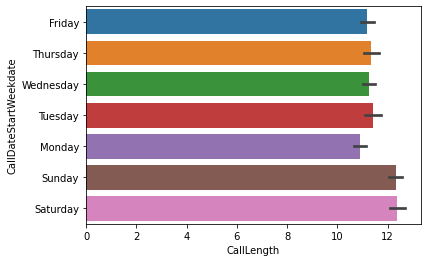

In [35]:
sns.barplot(data=crisis1, x="CallLength", y="CallDateStartWeekdate", 
            #hue="CRISIS Demographics - Gender Identity"
           )

Mondays am i right lol

g = sns.FacetGrid(
    crisis1, 
    row="CallDateStartMonth",
    #col="CRISIS Demographics - Gender Identity"
    )
g.map_dataframe(sns.histplot, x="CallDateStartTime")
#g.fig.set_size_inches(18, 10)
#g.set_axis_labels("Total Bill", "Frequency")

This wasn't working quite right and I need to relook at it before adding it into my thing

<AxesSubplot:xlabel='CallLength', ylabel='CallDateStartWeekdate'>

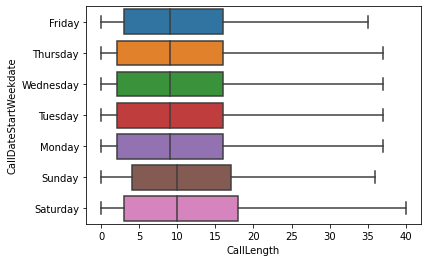

In [36]:
sns.boxplot(data=crisis1, x="CallLength", y="CallDateStartWeekdate", showfliers = False)
#no outliers call time chart

<AxesSubplot:xlabel='CallDateStartTime', ylabel='CallLength'>

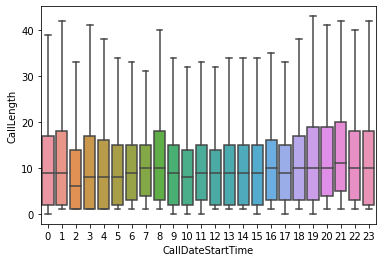

In [37]:
sns.boxplot(data=crisis1, x="CallDateStartTime", y="CallLength", showfliers = False)

Early morning (sunrise) has much lower call volume, while ~sunset~ tends to have more calls

<AxesSubplot:xlabel='CallDateStartTime', ylabel='Count'>

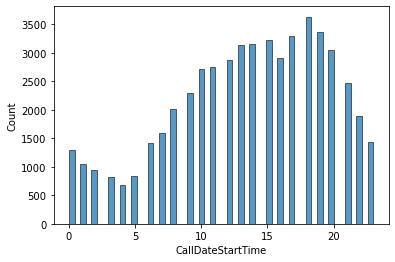

In [38]:
sns.histplot(data=crisis1, x="CallDateStartTime")

<AxesSubplot:xlabel='CallDateAndTimeStart', ylabel='CallLength'>

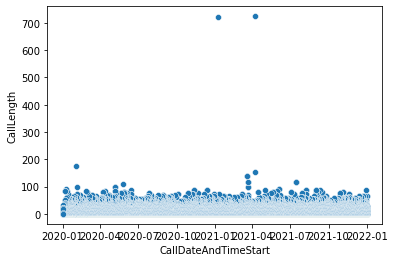

In [39]:
sns.scatterplot(x="CallDateAndTimeStart", y="CallLength", data=crisis1)

nvm guess this heatmap doesn't quite work for what i'm attempting

In [40]:
#sns.heatmap(crisis1['CallDateStartMonth'], crisis1['CallDateStartWeekdate'], crisis1['CallLength'], nnot=True, fmt="d")

In [41]:
crisis1['CallDateStartWeekdate']

0           Friday
1           Friday
2           Friday
3           Friday
4           Friday
           ...    
52871    Wednesday
52872    Wednesday
52873    Wednesday
52874    Wednesday
52875    Wednesday
Name: CallDateStartWeekdate, Length: 52876, dtype: object

This isn't quite panning out how i expected it to.

sns.set_theme(style="dark")

# Plot each year's time series in its own facet
g = sns.relplot(
    data=crisis1,
    x="CallDateStartWeekdate", y="CallReportNum", col="CallDateStartMonth", hue="CallDateStartMonth",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=crisis1, x="CallDateStartWeekdate", y="CallReportNum", units="CallDateStartMonth",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "Call Volume")
g.tight_layout()

In [43]:
import sunriset
import datetime
from datetime import timedelta
import math
import pytz

import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

I'm trying to add sunrise/sunset times to these charts, but first i really need to pull in the times of sunrise/sunset. Then maybe do a count of all the calls on that day, then work on charting items

In [117]:
lat = 36.174465
long = -86.767960
local_tz = -5

number_of_years = 4
start_date = datetime.date(2019,1,1)

nashvilletime = sunriset.to_pandas(start_date, lat, long, local_tz, number_of_years)
nashvilletime.reset_index(inplace=True)
nashvilletime

,index,Julian Day,Julian Century,Solar Geometric Mean Longitude,Solar Geometric Mean Anomaly,Eccentricity Earth Orbit,Solar Equation of Center,Solar True Longitude,Solar True Anomaly,Solar Radius Vector AUs,...,Sunrise,Sunset,Sunlight Durration (minutes),Ture Solar Time,Hour Angle Deg,Solar Zenith Angle (degrees),Solar Elevation Angle (degrees),Approximate Atmospheric Refraction (degrees),Solar Elevation Corrected ATM Refraction (degrees),Solar Azimuth Angle (degrees cw from North)
0,2019-01-01,2.458485e+06,0.190013,281.064494,7197.800393,0.016701,-0.075014,280.989479,7197.725379,0.983313,...,0 days 07:58:10.319402,0 days 17:43:02.946593,584.877120,669.389450,-12.652637,60.353207,29.646793,0.028251,29.675043,166.583446
1,2019-01-02,2.458486e+06,0.190040,282.050141,7198.785993,0.016701,-0.041409,282.008732,7198.744584,0.983304,...,0 days 07:58:19.573113,0 days 17:43:49.746883,585.502896,668.922333,-12.769417,60.289371,29.710629,0.028178,29.738807,166.441647
2,2019-01-03,2.458487e+06,0.190067,283.035788,7199.771594,0.016701,-0.007791,283.027997,7199.763802,0.983300,...,0 days 07:58:26.890102,0 days 17:44:37.792585,586.181708,668.460978,-12.884756,60.218093,29.781907,0.028097,29.810005,166.299212
3,2019-01-04,2.458488e+06,0.190095,284.021436,7200.757194,0.016701,0.025829,284.047265,7200.783023,0.983302,...,0 days 07:58:32.259463,0 days 17:45:27.035830,586.912939,668.005873,-12.998532,60.139394,29.860606,0.028009,29.888614,166.156230
4,2019-01-05,2.458489e+06,0.190122,285.007083,7201.742794,0.016701,0.059441,285.066524,7201.802235,0.983308,...,0 days 07:58:35.672210,0 days 17:46:17.428129,587.695932,667.557497,-13.110626,60.053304,29.946696,0.027912,29.974608,166.012788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2022-12-26,2.459940e+06,0.229848,275.181408,8631.848800,0.016699,-0.277032,274.904376,8631.571769,0.983476,...,0 days 07:56:35.652874,0 days 17:38:50.906707,582.254231,672.278670,-11.930332,60.580712,29.419288,0.028511,29.447800,167.414706
1456,2022-12-27,2.459941e+06,0.229876,276.167055,8632.834401,0.016699,-0.243733,275.923322,8632.590667,0.983437,...,0 days 07:56:56.135685,0 days 17:39:29.327946,582.553204,671.787803,-12.053049,60.561615,29.438385,0.028489,29.466874,167.278555
1457,2022-12-28,2.459942e+06,0.229903,277.152703,8633.820001,0.016699,-0.210359,276.942344,8633.609642,0.983402,...,0 days 07:57:14.787141,0 days 17:40:09.262169,582.907917,671.299589,-12.175103,60.535001,29.464999,0.028459,29.493458,167.141231
1458,2022-12-29,2.459943e+06,0.229930,278.138350,8634.805601,0.016699,-0.176917,277.961433,8634.628684,0.983373,...,0 days 07:57:31.584748,0 days 17:40:50.667335,583.318043,670.814566,-12.296359,60.500873,29.499127,0.028419,29.527546,167.002826


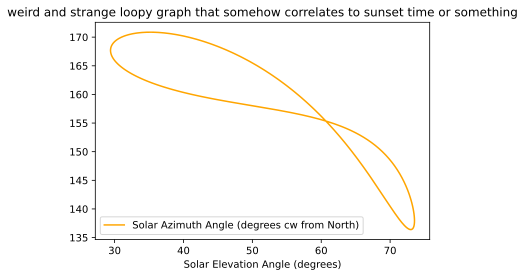

In [118]:
nashvilletime.plot(x='Solar Elevation Angle (degrees)', 
        y='Solar Azimuth Angle (degrees cw from North)', 
        color='orange',
        title='weird and strange loopy graph that somehow correlates to sunset time or something')
plt.show()

In [119]:
nashvillesun = nashvilletime[['index','Sunrise','Sunset']]

In [120]:
nashvillesun['Sunrise'] = nashvillesun['Sunrise'].astype('str')
nashvillesun['Sunset'] = nashvillesun['Sunset'].astype('str')
nashvillesun['Sunrise'] = nashvillesun['Sunrise'].str.replace('0 days ' , '')
nashvillesun['Sunset'] = nashvillesun['Sunset'].str.replace('0 days ' , '')
nashvillesun['Sunrise'] = nashvillesun['Sunrise'].str.replace(r'.\d{6}' , '')
nashvillesun['Sunset'] = nashvillesun['Sunset'].str.replace(r'.\d{6}' , '')
nashvillesun

C:\Users\phili\AppData\Local\Temp/ipykernel_10440/3443099234.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nashvillesun['Sunrise'] = nashvillesun['Sunrise'].astype('str')
C:\Users\phili\AppData\Local\Temp/ipykernel_10440/3443099234.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nashvillesun['Sunset'] = nashvillesun['Sunset'].astype('str')
C:\Users\phili\AppData\Local\Temp/ipykernel_10440/3443099234.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

,index,Sunrise,Sunset
0,2019-01-01,07:58:10,17:43:02
1,2019-01-02,07:58:19,17:43:49
2,2019-01-03,07:58:26,17:44:37
3,2019-01-04,07:58:32,17:45:27
4,2019-01-05,07:58:35,17:46:17
...,...,...,...
1455,2022-12-26,07:56:35,17:38:50
1456,2022-12-27,07:56:56,17:39:29
1457,2022-12-28,07:57:14,17:40:09
1458,2022-12-29,07:57:31,17:40:50


In [121]:
nashvillesun['index'] = nashvillesun['index'].astype('str')
nashvillesun['sunrisetime'] = (nashvillesun['index'] + ' ' + nashvillesun['Sunrise'])
nashvillesun['sunsettime'] = (nashvillesun['index'] + ' ' + nashvillesun['Sunset'])
nashvillesun['sunrisetime'] = pd.to_datetime(nashvillesun['sunrisetime'])
nashvillesun['sunsettime'] = pd.to_datetime(nashvillesun['sunsettime'])

nashvillesun

C:\Users\phili\AppData\Local\Temp/ipykernel_10440/1640190061.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nashvillesun['index'] = nashvillesun['index'].astype('str')
C:\Users\phili\AppData\Local\Temp/ipykernel_10440/1640190061.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nashvillesun['sunrisetime'] = (nashvillesun['index'] + ' ' + nashvillesun['Sunrise'])
C:\Users\phili\AppData\Local\Temp/ipykernel_10440/1640190061.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

,index,Sunrise,Sunset,sunrisetime,sunsettime
0,2019-01-01,07:58:10,17:43:02,2019-01-01 07:58:10,2019-01-01 17:43:02
1,2019-01-02,07:58:19,17:43:49,2019-01-02 07:58:19,2019-01-02 17:43:49
2,2019-01-03,07:58:26,17:44:37,2019-01-03 07:58:26,2019-01-03 17:44:37
3,2019-01-04,07:58:32,17:45:27,2019-01-04 07:58:32,2019-01-04 17:45:27
4,2019-01-05,07:58:35,17:46:17,2019-01-05 07:58:35,2019-01-05 17:46:17
...,...,...,...,...,...
1455,2022-12-26,07:56:35,17:38:50,2022-12-26 07:56:35,2022-12-26 17:38:50
1456,2022-12-27,07:56:56,17:39:29,2022-12-27 07:56:56,2022-12-27 17:39:29
1457,2022-12-28,07:57:14,17:40:09,2022-12-28 07:57:14,2022-12-28 17:40:09
1458,2022-12-29,07:57:31,17:40:50,2022-12-29 07:57:31,2022-12-29 17:40:50


<AxesSubplot:xlabel='Sunset', ylabel='Density'>

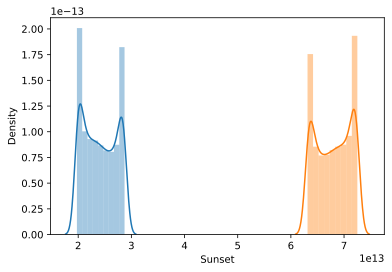

In [122]:
sns.distplot((nashvilletime['Sunrise']))
sns.distplot((nashvilletime['Sunset']))

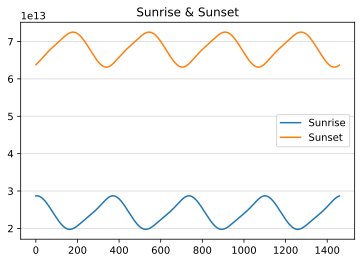

In [123]:
plt.plot(nashvilletime[['Sunrise','Sunset']])
plt.title('Sunrise & Sunset')
plt.legend(nashvilletime[['Sunrise','Sunset']])
plt.grid(axis='y', alpha=0.5)
plt.show()

Ok, so I've done all this, I've imported in the sunrise sunset times into the fold, now i need to merge them onto the original dataset so all of this isn't for not.
I'm going to start by merging them on month, which i know is probably a bad move. I'll instead get an average of the month and work with a single number?

In [124]:
nashvillesun['month'] = nashvillesun['sunrisetime'].dt.month

C:\Users\phili\AppData\Local\Temp/ipykernel_10440/1977952799.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nashvillesun['month'] = nashvillesun['sunrisetime'].dt.month


In [125]:
crisis1['index'] = crisis1['CallDateAndTimeStart'].dt.date
crisis1['index'] = crisis1['index'].astype(str)
crisis1['index']

0        2021-12-31
1        2021-12-31
2        2021-12-31
3        2021-12-31
4        2021-12-31
            ...    
52871    2020-01-01
52872    2020-01-01
52873    2020-01-01
52874    2020-01-01
52875    2020-01-01
Name: index, Length: 52876, dtype: object

In what some are describing to be a miracle, I have added on the sunset and sunrise time onto a spreadsheet based on the day. I can't believe it.

In [126]:
crisis00 = pd.merge(crisis1, nashvillesun, on = "index", how = "left")
crisis00 = crisis00[['CallDateAndTimeStart', 'CallDateAndTimeEnd', 'CallLength', 'index', 'Sunrise'
                    , 'Sunset', 'sunrisetime', 'sunsettime']]

<AxesSubplot:xlabel='count', ylabel='Nighttime'>

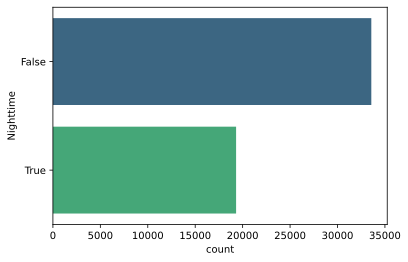

In [127]:
crisis00['Nighttime'] = (crisis00['CallDateAndTimeStart'].dt.time > crisis00['sunsettime'].dt.time) + (crisis00['CallDateAndTimeStart'].dt.time < crisis00['sunrisetime'].dt.time)

sns.countplot(y="Nighttime", data=crisis00, palette="viridis")

<AxesSubplot:xlabel='CallDateAndTimeStart', ylabel='CallLength'>

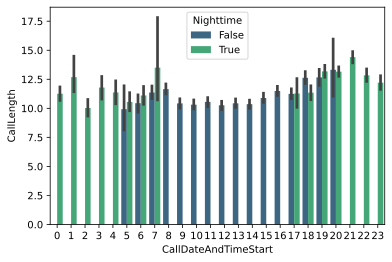

In [136]:
sns.barplot(x=crisis00['CallDateAndTimeStart'].dt.hour, y=crisis00['CallLength'], hue=crisis00['Nighttime'], palette="viridis")

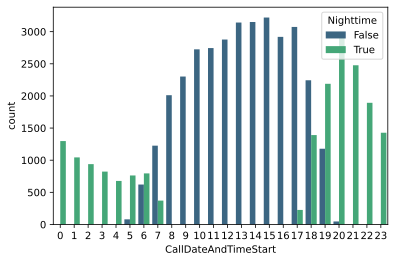

In [129]:
copl = sns.countplot(x=crisis00['CallDateAndTimeStart'].dt.hour.astype('int'), hue=crisis00['Nighttime'], palette="viridis")

<AxesSubplot:xlabel='CallDateAndTimeStart', ylabel='count'>

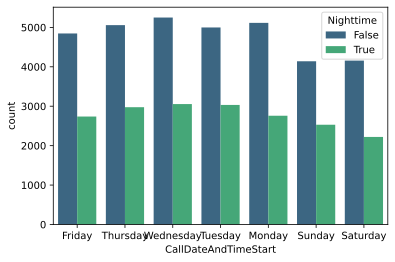

In [130]:
sns.countplot(x=crisis00['CallDateAndTimeStart'].dt.day_name(), hue=crisis00['Nighttime'], palette="viridis")

In [131]:
crisis00['month'] = crisis00['CallDateAndTimeStart'].dt.month
crisis00['hour'] = crisis00['CallDateAndTimeStart'].dt.hour
crisis00['year'] = crisis00['CallDateAndTimeStart'].dt.year
crisis00['day'] = crisis00['CallDateAndTimeStart'].dt.day
crisis00['weekday'] = crisis00['CallDateAndTimeStart'].dt.day_name()
crisis00.head()

,CallDateAndTimeStart,CallDateAndTimeEnd,CallLength,index,Sunrise,Sunset,sunrisetime,sunsettime,Nighttime,month,hour,year,day,weekday
0,2021-12-31 23:35:00,2021-12-31 23:58:00,23,2021-12-31,07:58:02,17:42:28,2021-12-31 07:58:02,2021-12-31 17:42:28,True,12,23,2021,31,Friday
1,2021-12-31 23:29:00,2021-12-31 23:35:00,6,2021-12-31,07:58:02,17:42:28,2021-12-31 07:58:02,2021-12-31 17:42:28,True,12,23,2021,31,Friday
2,2021-12-31 23:07:00,2021-12-31 23:28:00,21,2021-12-31,07:58:02,17:42:28,2021-12-31 07:58:02,2021-12-31 17:42:28,True,12,23,2021,31,Friday
3,2021-12-31 22:45:00,2021-12-31 22:55:00,10,2021-12-31,07:58:02,17:42:28,2021-12-31 07:58:02,2021-12-31 17:42:28,True,12,22,2021,31,Friday
4,2021-12-31 22:15:00,2021-12-31 22:44:00,29,2021-12-31,07:58:02,17:42:28,2021-12-31 07:58:02,2021-12-31 17:42:28,True,12,22,2021,31,Friday


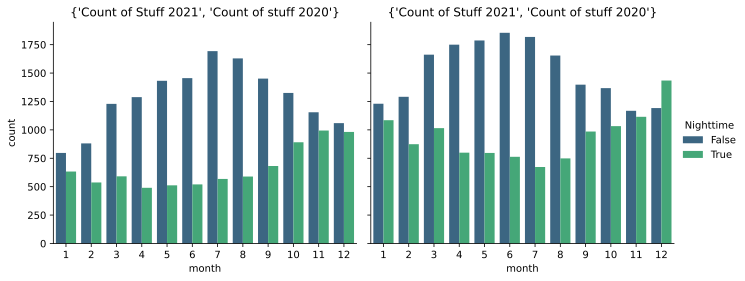

In [137]:
g = sns.catplot(x="month", hue="Nighttime", col="year",
                data=crisis00, kind="count",
                height=4, palette="viridis", 
                 aspect=1.2, legend_out=True,
               sharex=True, sharey=True).set(title={'Count of stuff 2020', 'Count of Stuff 2021'});

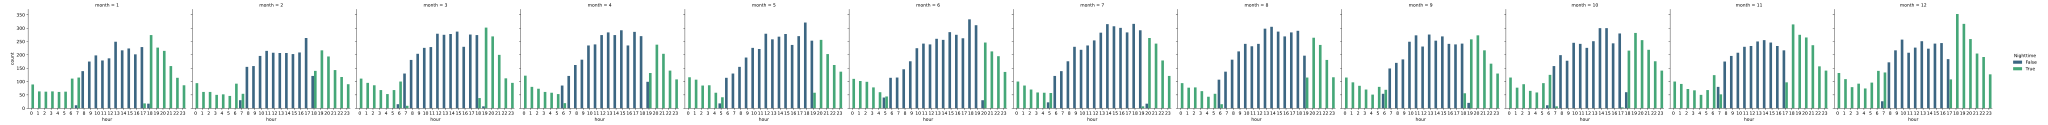

In [133]:
g = sns.catplot(x="hour", hue="Nighttime", col="month",
                data=crisis00, kind="count",
                height=4, palette="viridis", 
                 aspect=1.3, legend_out=True,
               sharex=True, sharey=True);

<AxesSubplot:xlabel='index', ylabel='count'>

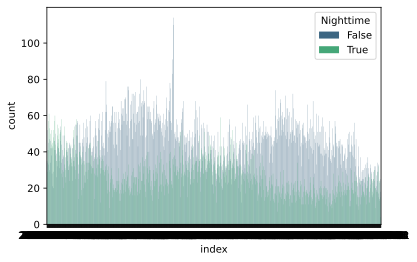

In [138]:
sns.countplot(x=crisis00['index'], hue=crisis00['Nighttime'], palette="viridis")

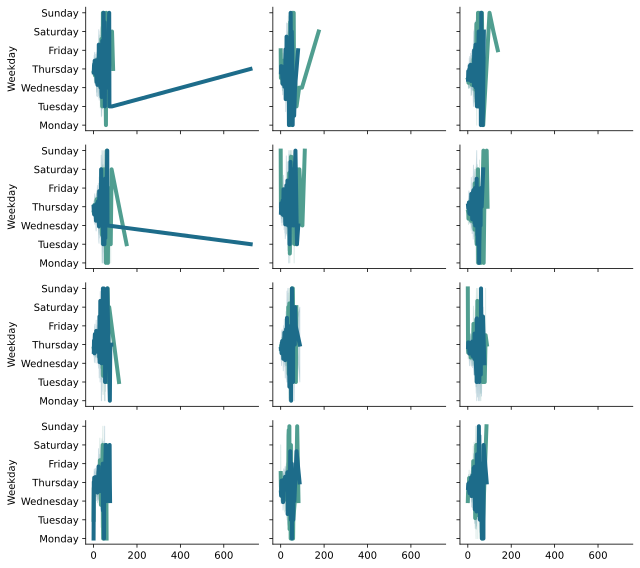

In [142]:
# Note, this is stolen code and it barely works right now
# Plot each year's time series in its own facet
g = sns.relplot(
    data=crisis00,
    x="CallLength", y="weekday", col="month", hue="Nighttime",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
#for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
#    ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
#    sns.lineplot(
#        data=crisis00, x="CallLength", y="weekday", units="month",
#        estimator=None, color=".7", linewidth=1, ax=ax,
#    )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "Weekday")
g.tight_layout()

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

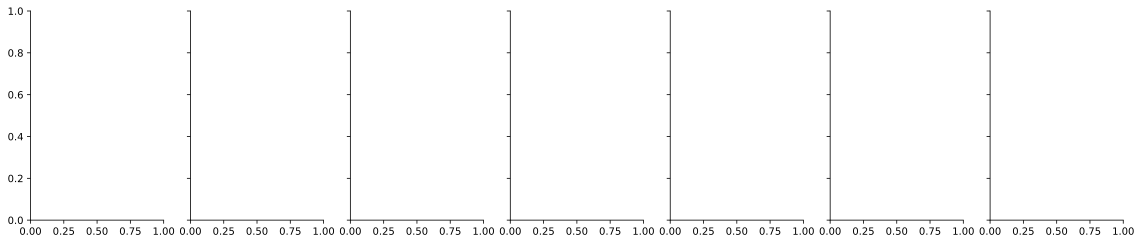

In [143]:
g = sns.FacetGrid(data=crisis00, col="weekday", height=3.5, aspect=.65)
g.map(sns.histplot, "Nighttime")